# Analysis of the Cackling Goose (Branta hutchinsii) and Associated Subspecies

Author: Carolyn Lee

In [42]:
import numpy as np
import pandas as pd
import warnings
import GooseUtils
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Supress warning related to data types (will get on first import of the csv file)
warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)

In [43]:
#
# Retrieve the data from the csv file and filter out irrelevant species
#

# Retrieve group 3 data from the relevant CSV file
goose_data_raw = pd.read_csv('NABBP_2023_grp_03.csv')

# Filter out all irrelevant species
goose_data_raw = goose_data_raw[(goose_data_raw['SPECIES_ID'] == 1721) | (goose_data_raw['SPECIES_ID'] == 1722)]

In [44]:
#
# Get all relevant columns and display basic information about the data
#

# Retrieve all relevant columns
goose_data = goose_data_raw[['BAND', 
                             'ORIGINAL_BAND', 
                             'OTHER_BANDS', 
                             'EVENT_DATE', 
                             'EVENT_DAY', 
                             'EVENT_MONTH', 
                             'EVENT_YEAR', 
                             'LAT_DD', 
                             'LON_DD', 
                             'COORD_PREC']]

# Display number of non-null entries in each column
display(goose_data.count())

BAND             73309
ORIGINAL_BAND    73309
OTHER_BANDS         39
EVENT_DATE       73309
EVENT_DAY        73309
EVENT_MONTH      73309
EVENT_YEAR       73309
LAT_DD           73278
LON_DD           73278
COORD_PREC       73300
dtype: int64

A large number of the date cells do not work with the pd.to_datetime() function. Since this is vital information for the analysis, the below cell aims specifically to clean the dates and remove any unessesary columns after. The following is the process by which dates are chosen.

If the 'EVENT_DATE' column already has a valid date that works with pd.to_datetime(), it will be the date used.
Otherwise, if the 'EVENT_DAY', 'EVENT_MONTH', and 'EVENT_YEAR' column all form a date that works with pd.to_datetime(), it will be the date used.
If neither of the above work, NaT will be assigned and the row will be dropped.

In [45]:
#
# Clean time-related columns as described above.

goose_data['EVENT_DATE'] = pd.to_datetime(goose_data['EVENT_DATE'], format='%m/%d/%Y', errors='coerce')

# Assemble date guesses from the EVENT_MONTH, EVENT_DAY, and EVENT_YEAR columns BEFORE DROPPING THEM
dates_from_columns = pd.to_datetime(
    goose_data['EVENT_MONTH'].astype(str) + '/' +
    goose_data['EVENT_DAY'].astype(str) + '/' +
    goose_data['EVENT_YEAR'].astype(str),
    format='%m/%d/%Y',
    errors='coerce'
)

# Fill in all NaT values that can be filled with the guesses from the previous line.
goose_data['EVENT_DATE'] = goose_data['EVENT_DATE'].fillna(dates_from_columns)

# Remove all rows where EVENT_DATE is still NaT after the above operations.
goose_data = goose_data[goose_data['EVENT_DATE'].notna()]

# drop EVENT_MONTH, EVENT_DAY, and EVENT_YEAR columns
goose_data = goose_data.drop(labels=['EVENT_MONTH', 'EVENT_DAY', 'EVENT_YEAR'], axis=1)


/var/folders/_9/n_lpr4gj0f3fl6nv_b83c5x00000gp/T/ipykernel_3765/3914865308.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  goose_data['EVENT_DATE'] = pd.to_datetime(goose_data['EVENT_DATE'], format='%m/%d/%Y', errors='coerce')
/var/folders/_9/n_lpr4gj0f3fl6nv_b83c5x00000gp/T/ipykernel_3765/3914865308.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  goose_data['EVENT_DATE'] = goose_data['EVENT_DATE'].fillna(dates_from_columns)


In [48]:
#
# Clean the coordinates columns as described above.
#

# Filter out all rows where LAT_DD or LON_DD are NaN. Cannot rectify rows with this issue.
goose_data = goose_data[goose_data['LAT_DD'].notna() & goose_data['LON_DD'].notna()]

# Filter out all rows with unusable or useless coordinate precision values as outlined above.

goose_data = goose_data[~((goose_data['COORD_PREC'] == 8)  | \
                            (goose_data['COORD_PREC'] == 12) | \
                            (goose_data['COORD_PREC'] == 18) | \
                            (goose_data['COORD_PREC'] == 28) | \
                            (goose_data['COORD_PREC'] == 33) | \
                            (goose_data['COORD_PREC'] == 38) | \
                            (goose_data['COORD_PREC'] == 72) | \
                            (goose_data['COORD_PREC'].isna()))]

In [49]:
#
# Perform the coordinate precision conversion as described above.
#

# Compute coording uncertainties
goose_data['COORD_UNC'] = goose_data['COORD_PREC'].apply(lambda x : GooseUtils.get_coord_unc(x))

# Drop the old column
goose_data = goose_data.drop(labels=['COORD_PREC'], axis=1)

Creating heatmap with 72522 coordinate points


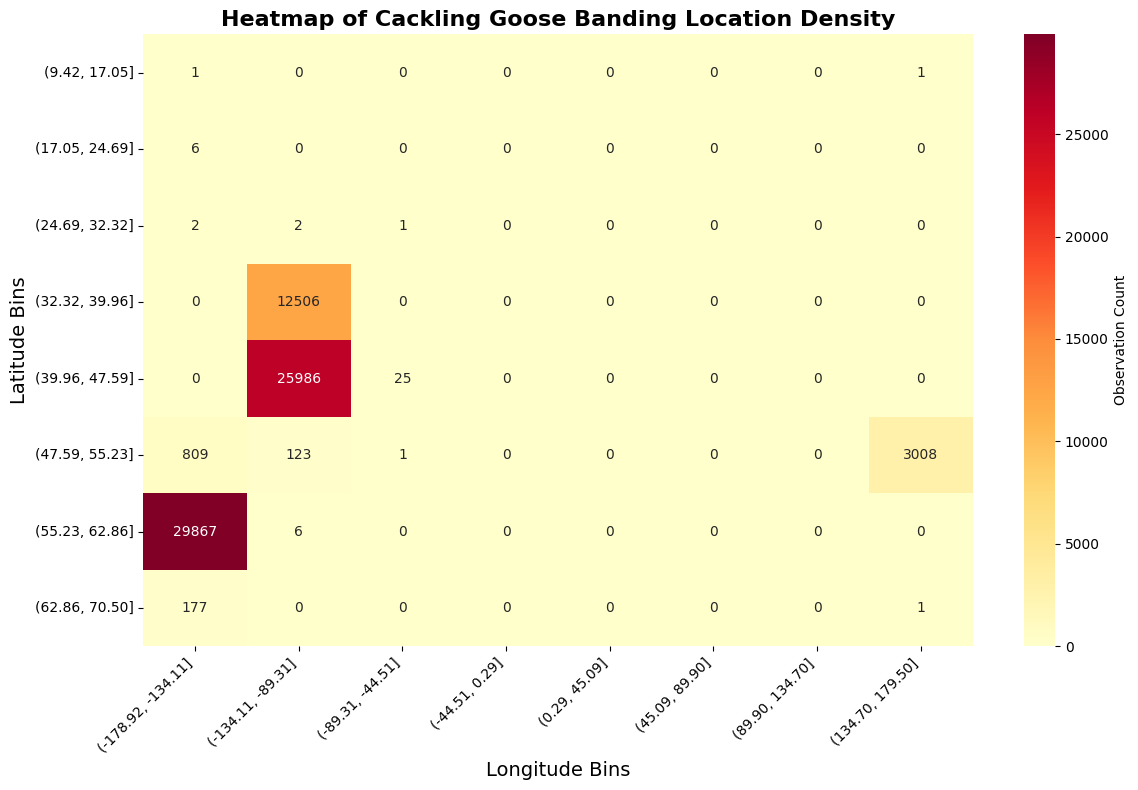

In [50]:
def create_heatmap(data, bins=8):
        
    # Get coordinate values, dropping NaN
    lat_values = data['LAT_DD'].dropna().values
    lon_values = data['LON_DD'].dropna().values
    
    if len(lat_values) == 0 or len(lon_values) == 0:
        print("Error: No valid coordinate data found!")
        print(f"LAT_DD non-null count: {len(lat_values)}")
        print(f"LON_DD non-null count: {len(lon_values)}")
        return
    
    print(f"Creating heatmap with {len(lat_values)} coordinate points")
    
    # Create bins
    lat_bins = np.linspace(lat_values.min(), lat_values.max(), bins + 1)
    lon_bins = np.linspace(lon_values.min(), lon_values.max(), bins + 1)
    
    # Calculate 2D histogram
    counts, lat_edges, lon_edges = np.histogram2d(lat_values, lon_values, 
                                                  bins=[lat_bins, lon_bins])
    
    # Create bin labels
    lat_labels = [f"({lat_edges[i]:.2f}, {lat_edges[i+1]:.2f}]" 
                  for i in range(len(lat_edges)-1)]
    lon_labels = [f"({lon_edges[i]:.2f}, {lon_edges[i+1]:.2f}]" 
                  for i in range(len(lon_edges)-1)]
    
    # Create the heatmap
    plt.figure(figsize=(12, 8))
    
    sns.heatmap(counts, 
                xticklabels=lon_labels,
                yticklabels=lat_labels,
                cmap='YlOrRd',
                cbar_kws={'label': 'Observation Count'},
                annot=True,
                fmt='.0f')
    
    plt.title('Heatmap of Cackling Goose Banding Location Density', fontsize=16, fontweight='bold')
    plt.xlabel('Longitude Bins', fontsize=14)
    plt.ylabel('Latitude Bins', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Try to create the heatmap
create_heatmap(goose_data, bins=8)

In [51]:
def run_statistical_analysis(data, bins=8):
    # Get coordinate values
    lat_values = data['LAT_DD'].dropna().values
    lon_values = data['LON_DD'].dropna().values

    if len(lat_values) == 0 or len(lon_values) == 0:
        print("Error: No valid coordinate data found!")
        return

    # Create 2D histogram
    lat_bins = np.linspace(lat_values.min(), lat_values.max(), bins + 1)
    lon_bins = np.linspace(lon_values.min(), lon_values.max(), bins + 1)
    counts, _, _ = np.histogram2d(lat_values, lon_values, bins=[lat_bins, lon_bins])

    # Filter out empty rows/columns to prevent zero expected frequencies
    counts = counts[(counts.sum(axis=1) != 0), :]  # Remove zero-rows
    counts = counts[:, (counts.sum(axis=0) != 0)]  # Remove zero-columns

    # Chi-Squared Test for uniformity
    if counts.size == 0 or counts.shape[0] < 2 or counts.shape[1] < 2:
        print("Not enough non-zero bins to perform chi-squared test.")
        return

    chi2_stat, p_value, dof, expected = chi2_contingency(counts)

    # Dataset summary statistics
    summary = {
        'num_entries': len(data),
        'num_features': data.shape[1],
        'missing_lat': data['LAT_DD'].isna().sum(),
        'missing_lon': data['LON_DD'].isna().sum(),
        'coord_unc_mean': data['COORD_UNC'].mean(),
        'coord_unc_max': data['COORD_UNC'].max(),
        'coord_unc_min': data['COORD_UNC'].min(),
        'lat_range': (data['LAT_DD'].min(), data['LAT_DD'].max()),
        'lon_range': (data['LON_DD'].min(), data['LON_DD'].max())
    }

    print("Dataset Summary:")
    for k, v in summary.items():
        print(f"  {k}: {v}")

    print("\nChi-Squared Test for Uniformity:")
    print(f"  Chi² Statistic = {chi2_stat:.4f}")
    print(f"  p-value = {p_value:.4f}")
    print("Conclusion:", 
          "No significant spatial clustering (uniform)" if p_value > 0.05 
          else "Significant spatial clustering (non-uniform)")

# Run the analysis
run_statistical_analysis(goose_data, bins=8)


Dataset Summary:
  num_entries: 72522
  num_features: 7
  missing_lat: 0
  missing_lon: 0
  coord_unc_mean: 0.44954414184661207
  coord_unc_max: 0.5
  coord_unc_min: 5e-06
  lat_range: (9.41667, 70.5)
  lon_range: (-178.91667, 179.5)

Chi-Squared Test for Uniformity:
  Chi² Statistic = 126637.4264
  p-value = 0.0000
Conclusion: Significant spatial clustering (non-uniform)


Null hypothesis: goose banding events are uniformly distributed across the geographic space (each spatial bin is equally likely to contain a banding event). 

Very high Chi² statistic (126,637) indicates a large discrepancy between observed and expected counts.
Since p-value = 0.0000 < 0.0001, Reject the null hypothesis:
Goose banding events are spatially clustered, not uniformly spread. Since p-value essentially zero, result is highly statistically significant. 

Conclusion: There is significant spatial clustering (non-uniform). This means that certain geographic regions (likely in the Northern latitudes) are much more heavily sampled or occupied. This could be due to Goose migration patterns, Habitat availability, Research/survey effort, and/or Accessibility of locations.